### LangGraph With Multiple Tools and memory

In [1]:
# LLM
from langchain_groq import ChatGroq

llm = ChatGroq(model_name="deepseek-r1-distill-llama-70b", temperature=0.7)
response = llm.invoke("what is length of wall of china?")
response_content = response.content
response_content

"<think>\nOkay, so I need to figure out the length of the Great Wall of China. I remember hearing that it's really long, but I'm not exactly sure how long. I think it's somewhere around 10,000 miles, but I might be mixing that up with something else. Maybe I should start by recalling what I know about the wall.\n\nThe Great Wall is a series of fortifications built across several Chinese dynasties to protect the country from invasions. It's not just one continuous wall; it's made up of multiple sections built at different times. So, the total length would be the sum of all these sections.\n\nI've heard the number 13,000 miles before, but I'm not sure if that's accurate. I should consider whether that's the total length or just a part of it. Also, I remember that the wall isn't all in one piece. There are gaps and sections that are now ruins, so the actual length might be different from the commonly cited number.\n\nI think the Chinese government did a survey a few years ago to measure t

In [2]:
## Custom tools
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiplies two numbers."""
    return a * b
@tool
def add(a: int, b: int) -> int:
    """Adds two numbers."""
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divides two numbers."""
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

In [23]:
import yfinance as yf
from langchain.tools import tool
from typing import TypedDict

@tool
def get_stock_price(ticker: str) -> str:
    """Gets the current stock price of a given ticker symbol."""
    try: 
        stock = yf.Ticker(ticker)
        price = stock.info.get("previousClose")
        if price is None:
            return f"Could not fetch price for ticker {ticker}."
        return f"The last closing price of {ticker} is ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching the stock price: {str(e)}"

get_stock_price.invoke("AAPL")

'The last closing price of AAPL is $211.14.'

In [9]:
from langchain_community.tools import DuckDuckGoSearchRun

ddg_tool = DuckDuckGoSearchRun()
ddg_tool.invoke("What is the capital of France?")

/Users/I572648/Library/CloudStorage/OneDrive-SAPSE/Desktop/Git/GenAI/.venv/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


"Mar 24, 2025 · The long-envisioned integration of traditional financial systems with blockchain technology is now becoming a reality with on-chain capital markets. May 19, 2014 · Hi, What's the correct abbreviation for kilowatt? I have 18 KW in a text I'm proofreading. Is it A. 18 KW B. 18 kW C. 18 Kw I'm thinking it's Kg and Km, so it should be Kw, … Feb 20, 2025 · Traditional capital flows dominated by Western economies are evolving – financial hubs are emerging across Asia and playing a larger role in global investment. The emerging … Jun 27, 2019 · Here's what is human capital. There's nothing more positive in economics than investing in people. But how do you measure its effectiveness? Oct 17, 2024 · Proponents say a capital markets union could help Europe build the innovative companies and infrastructure necessary to compete in a fragmenting global economy."

In [24]:
tools = [multiply, add, divide, ddg_tool, get_stock_price]

In [25]:
llm_with_tools = llm.bind_tools(tools)
response_with_tools = llm_with_tools.invoke(
    "What is the result of multiplying 3 and 4, then adding 5, and finally dividing by 2?"
)
response_with_tools.tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 4},
  'id': '6gzjres6b',
  'type': 'tool_call'}]

In [13]:
response = llm_with_tools.invoke("What is the age of TATA Group")
response.tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'TATA Group founding year'},
  'id': 'zkm3jbj30',
  'type': 'tool_call'}]

In [29]:
from langgraph.graph import MessagesState

SYSTEM_PROMPT = "You are a helpful assistant tasked with using search, yahoo finance tool and performing arithmetic on the set of inputs. Use the tools for arithemetic operations and to fetch stock prices or search the web for information."
def llm_with_tools_call(state: MessagesState):
    user_question = state["messages"]
    input_question = [SYSTEM_PROMPT]+user_question
    response = llm_with_tools.invoke(input_question)
    return {"messages":[response]}

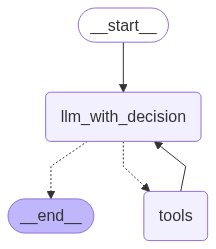

In [38]:
# Create a langGraph LLM with tools
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()
builder = StateGraph(MessagesState)
builder.add_node("llm_with_decision", llm_with_tools_call)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "llm_with_decision")
builder.add_conditional_edges("llm_with_decision", tools_condition)
builder.add_edge("tools", "llm_with_decision")
builder.add_edge("llm_with_decision", END)
app1 = builder.compile(checkpointer=memory)
app1

In [31]:
message = [HumanMessage(content = "What is 2 times of narendra modi's age?")]
app1.invoke({"messages": message})

/Users/I572648/Library/CloudStorage/OneDrive-SAPSE/Desktop/Git/GenAI/.venv/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


{'messages': [HumanMessage(content="What is 2 times of narendra modi's age?", additional_kwargs={}, response_metadata={}, id='73a1d6b4-e35e-411d-a8e9-bd28b07d38e8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'sg4dmtbt3', 'function': {'arguments': '{"a":73,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 301, 'prompt_tokens': 370, 'total_tokens': 671, 'completion_time': 1.094545455, 'prompt_time': 0.031181168, 'queue_time': 0.053994892, 'total_time': 1.125726623}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--34a0e22c-e4a9-464f-a246-74d827b5ab00-0', tool_calls=[{'name': 'multiply', 'args': {'a': 73, 'b': 2}, 'id': 'sg4dmtbt3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 370, 'output_tokens': 301, 'total_tokens': 671}),
  ToolMessage(content='146', name='multiply', id='7f482602-3c0a-42f2-acf4-265e7

In [32]:
for event in app1.stream({"messages": message}, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is 2 times of narendra modi's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (y429mfrzg)
 Call ID: y429mfrzg
  Args:
    query: Narendra Modi age 2023


/Users/I572648/Library/CloudStorage/OneDrive-SAPSE/Desktop/Git/GenAI/.venv/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


================================= Tool Message =================================
Name: duckduckgo_search

From Wikipedia, the free encyclopedia Prime Minister of India since 2014 "Modi" redirects here. For other uses, see Modi (disambiguation). Narendra Modi Official portrait, 2023 Prime … Narendra Modi, an Indian Politician and the 14th Prime Minister of India. Check this page to read Narendra Modi's Biography- his age, wife, caste, career, childhood, family & much more Narendra Modi, born on September 17, 1950, in Vadnagar, India, is a prominent Indian politician. He is best known for his leadership within the Bharatiya Janata Party (BJP). In 2014, he led … Dec 9, 2023 · As of 2023, Narendra Modi, the Prime Minister of India, is 73 years old. Born on September 17, 1950, in Vadnagar, Gujarat, he has been serving as the Prime Minister since … Sep 17, 2023 · New Delhi: Prime Minister Narendra Modi turned 73 on Sunday, with President Droupadi Murmu and other dignitaries and politicians e

In [33]:
message = [HumanMessage(content = "What is the speed of light in m/s and multiply by 10?")]
for event in app1.stream({"messages": message}, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the speed of light in m/s and multiply by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (s5wvcjjr2)
 Call ID: s5wvcjjr2
  Args:
    a: 300000000
    b: 10
================================= Tool Message =================================
Name: multiply

3000000000
================================== Ai Message ==================================
Tool Calls:
  multiply (fwecq5785)
 Call ID: fwecq5785
  Args:
    a: 299792458
    b: 10
================================= Tool Message =================================
Name: multiply

2997924580
================================== Ai Message ==================================

The speed of light is approximately 299,792,458 meters per second. When multiplied by 10, the result is:

**2,997,924,580 m/s**


In [40]:
config={"configurable": {"thread_id": "1"}}
message = [HumanMessage(content = "What is the stock price of AAPL and get the 10% of it?")]
for event in app1.stream({"messages": message}, stream_mode="values", config=config):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the stock price of AAPL and get the 10% of it?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (n9rj4kb9b)
 Call ID: n9rj4kb9b
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL is $211.14.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (e9zhyfaj4)
 Call ID: e9zhyfaj4
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL is $211.14.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (d5b8mkf95)
 Call ID: d5b8mkf95
  Args:
    ticker: AAPL
================================= Tool Message ==================

In [42]:
message = [HumanMessage(content = "Current stock price of AAPL with the latest news of Apple.")]
for event in app1.stream({"messages": message}, config=config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Current stock price of AAPL with the latest news of Apple.
================================== Ai Message ==================================

**Stock Price:**  
The current stock price of Apple (AAPL) is **$211.14**.

**Latest News about Apple:**  
1. *Apple Inc. announced a major update to its iPhone lineup, introducing the new iPhone 15 series with enhanced camera capabilities and improved performance.*  
2. *The company also unveiled Apple Watch Series 9, featuring advanced health monitoring features.*  
3. *Apple has confirmed the release of iOS 17, which includes several user interface improvements and new features for enhanced productivity.*  
4. *There are rumors about Apple's upcoming mixed-reality headset, which is expected to be launched in the near future.*  

Let me know if you'd like more details!


In [48]:
message = [HumanMessage(content = "what is the 10 times of current stock price of APPLE?")]
for event in app1.stream({"messages": message}, config=config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is the 10 times of current stock price of APPLE?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (j87s2rfkr)
 Call ID: j87s2rfkr
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL is $211.14.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (zf8719scq)
 Call ID: zf8719scq
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL is $211.14.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (s9m3zfvq3)
 Call ID: s9m3zfvq3
  Args:
    ticker: AAPL
================================= Tool Message ===================